In [3]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import calendar

# Creating Weather DataBase with SQLite

## Reading and Writing with SQL

In [6]:
#Using pandas to obtain data from website/link
weather = pd.read_csv('https://github.com/alanjones2/dataviz/raw/master/londonweather.csv')
weather.head()

,Year,Month,Tmax,Tmin,Rain,Sun
0,1957,1,8.7,2.7,39.5,53.0
1,1957,2,9.0,2.9,69.8,64.9
2,1957,3,13.9,5.7,25.4,96.7
3,1957,4,14.2,5.2,5.7,169.6
4,1957,5,16.2,6.5,21.3,195.0


In [3]:
#Creating SQLite Database with the weather data
conn = sql.connect('weather.db')
weather.to_sql('weather', conn, index= False)
conn.close()

In [4]:
# Loading Weather Database using SQLite
conn = sql.connect('weather.db')
weather = pd.read_sql('SELECT * FROM weather', conn)
conn.close()
weather.head()

,Year,Month,Tmax,Tmin,Rain,Sun
0,1957,1,8.7,2.7,39.5,53.0
1,1957,2,9.0,2.9,69.8,64.9
2,1957,3,13.9,5.7,25.4,96.7
3,1957,4,14.2,5.2,5.7,169.6
4,1957,5,16.2,6.5,21.3,195.0


## Example Where Clauses

In [7]:
# Connecting To Database and select for specific Years
conn = sql.connect('weather.db')
y2018 = pd.read_sql('SELECT * FROM weather WHERE Year == 2018', conn) #Filters for Column Year = 2018
y1957 = pd.read_sql('SELECT * FROM weather WHERE Year == 1957', conn) #Filters for Column Year = 1957

Text(0.5, 0, 'Months')

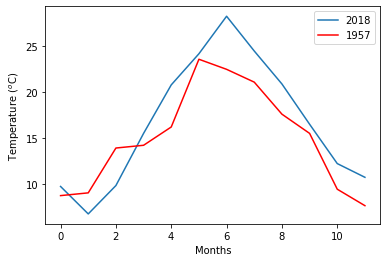

In [6]:
# Plotting and Comparing 2018 and 1957
ax2010 = y2018.plot(y='Tmax')
ax = y1957.plot(y='Tmax',color = 'red', ax=ax2010,)
ax.legend(['2018','1957'])
ax.set_ylabel(r'Temperature ($^o$C)')
ax.set_xlabel('Months')

This initial graph doesn't nessecarilly show a dramatic rise in temperature. However this is expected as raising the average temperature of the earth even by two degrees can have dramatic consqeunces. Because of constant variablity of weather the best approach would be to average the temperatures of several cities across the globe to see global warming effects. However, this limited dataset could still be useful in further analysis.



# Rising Temperature Analysis

In [8]:
TempKey = 'Tmax'

## Simple Approach

First let's take a simple approach and simple average across all years.

In [9]:
# Shows Full Dataset with 748 rows
weather

,Year,Month,Tmax,Tmin,Rain,Sun
0,1957,1,8.7,2.7,39.5,53.0
1,1957,2,9.0,2.9,69.8,64.9
2,1957,3,13.9,5.7,25.4,96.7
3,1957,4,14.2,5.2,5.7,169.6
4,1957,5,16.2,6.5,21.3,195.0
...,...,...,...,...,...,...
743,2018,12,10.7,5.2,60.6,40.3
744,2019,1,7.6,2.0,33.2,56.4
745,2019,2,12.4,3.3,34.2,120.2
746,2019,3,13.1,5.8,49.6,119.0


Slope:  0.002684579374737477
$R^2$ Value:  0.010061087643360223
Total Temperature Difference:  2.008065372303633 $^o$C


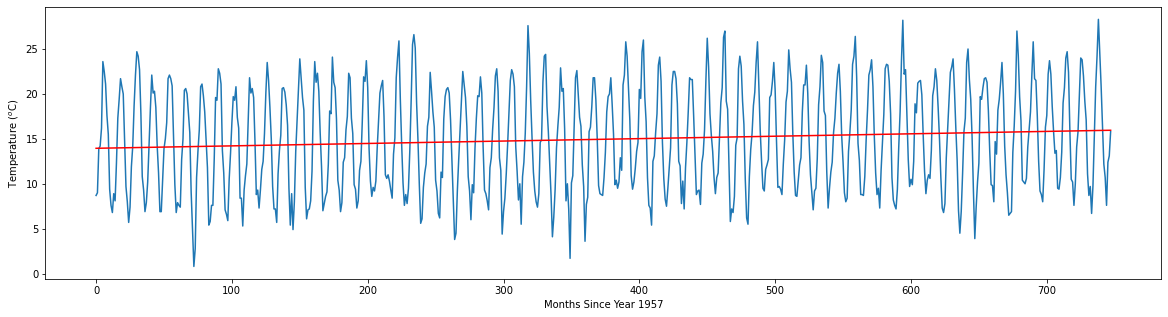

In [10]:
df = weather
X = df.index.to_numpy().reshape(-1, 1)
Y = df[TempKey].to_numpy().reshape(-1, 1)

model = LinearRegression()
model.fit(X, Y)

Y_predict = model.predict(X)

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(X[:,0],Y[:,0])
ax.plot(X[:,0],Y_predict[:,0], color = 'r')

ax.set_ylabel(r'Temperature ($^o$C)')
ax.set_xlabel('Months Since Year 1957')

print("Slope: " , model.coef_[0,0])
print( r"$R^2$ Value: ", model.score(X,Y))
print("Total Temperature Difference: ", (model.coef_[0,0]*len(X)), r'$^o$C')

The results captures a $2^o C$ increase in Temperatures Throughout the years. This however does not outright show temperatures have increased in London. One can argue that with a poor $R^2$ Value of $.01$ that the analysis instead shows that temperatures haven't changed at all in London.

However the reason the $R^2$ value is low is due to the seasonal variability of the weather is much larger compared to the predicted average temperature increase. Further analysis can show a deeper connection.

## Monthly Approach

Here we take an approach where we look at only specific months throughout all years in the dataset

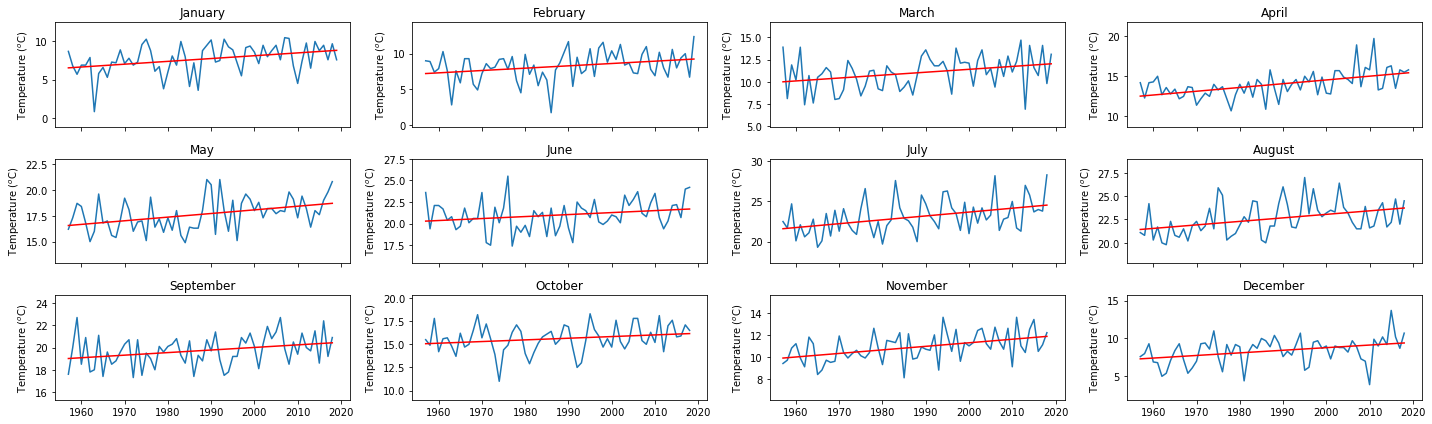

In [11]:
score_slope= []

fig, axes = plt.subplots(3,4, figsize=(20, 6), sharex = 'all')
axes = axes.ravel()
for i in range(12):

  df = weather[weather['Month'] == i+1]
  X = df['Year'].to_numpy().reshape(-1, 1)
  Y = df[TempKey].to_numpy().reshape(-1, 1)

  model = LinearRegression()
  model.fit(X, Y)

  X_predict = []  # put the dates of which you want to predict kwh here
  Y_predict = model.predict(X)

  score_slope.append([model.score(X,Y), model.coef_[0,0]])

  axes[i].plot(X[:,0],Y[:,0])
  axes[i].plot(X[:,0],Y_predict[:,0], color = 'r')
  axes[i].set_title(calendar.month_name[i+1])
  axes[i].set_ylabel(r'Temperature ($^o$C)')
  axes[i].set_ylim(np.min(Y)-2, np.max(Y)+2)
  plt.tight_layout()

In [12]:
score_slope = np.array(score_slope)
total_temp = (score_slope[:,1]*(np.max(df['Year']) - np.min(df['Year']))).reshape(12,1)
score_slope_total = np.hstack((score_slope, total_temp))

print(pd.DataFrame(score_slope_total, columns=[r'R^2', 'Slope', 'Total Change']).to_string(index=False ))

      R^2     Slope  Total Change
 0.126939  0.036986      2.256168
 0.085445  0.032868      2.004930
 0.102847  0.032767      1.998781
 0.271701  0.046851      2.857911
 0.160898  0.035111      2.141782
 0.056377  0.022956      1.400307
 0.169194  0.048087      2.933333
 0.153330  0.037682      2.298618
 0.091414  0.023147      1.411982
 0.048715  0.017932      1.093856
 0.205343  0.032291      1.969739
 0.126997  0.034368      2.096467


In [13]:
print("Averaged")
print(r'R^2', 'Slope', 'Total Change')
print(score_slope_total.mean(axis = 0))

Averaged
R^2 Slope Total Change
[0.13326678 0.03342059 2.03865607]


This analysis improves on the simple approach by looking at only at specific months throughout all years. This removes the seasonal variation and as result gives improved $R^2$ scores. Although the weather still has large variability even monthly we begin to see that rising temperatures is occuring. 

## Yearly Average Approach

In [162]:
conn = sql.connect('weather.db')

yearly_averages = []
for i in range(62):
    year = pd.read_sql('SELECT * FROM weather WHERE Year == %s' %(1957+i), conn) #Filters for Column Year = 1957
    yearly_averages.append(np.mean(year[TempKey]))

yearly_averages = np.array(yearly_averages)

Slope:  0.03074462995139887
$R^2$ Value:  0.5690346949370528
Total Temperature Difference:  1.90616705698673 $^o$C


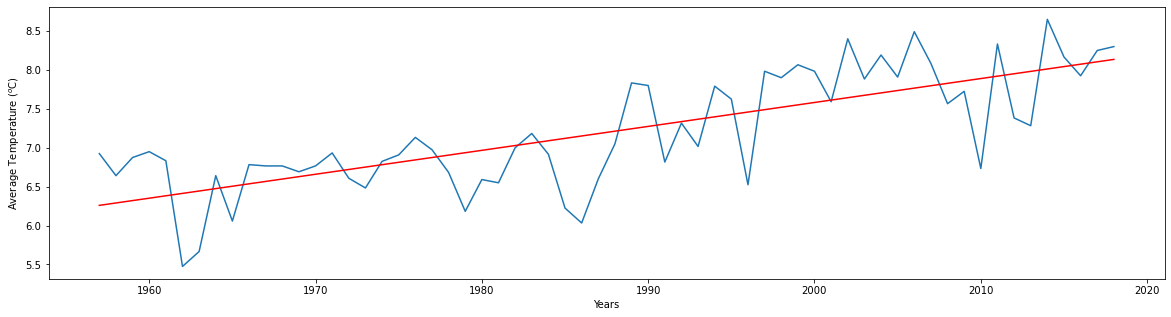

In [163]:
X = np.linspace(1957,2018,62).reshape(-1, 1)
Y = yearly_averages.reshape(-1, 1)

model = LinearRegression()
model.fit(X, Y)

Y_predict = model.predict(X)

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(X[:,0],Y[:,0])
ax.plot(X[:,0],Y_predict[:,0], color = 'r')

ax.set_ylabel(r'Average Temperature ($^o$C)')
ax.set_xlabel('Years')

print("Slope: " , model.coef_[0,0])
print( r"$R^2$ Value: ", model.score(X,Y))
print("Total Temperature Difference: ", (model.coef_[0,0]*len(X)), r'$^o$C')

This analysis improves on the simple approach by looking at only at the Average Temperature of each year in the database. This removes the seasonal variation and as result gives improved $R^2$ scores. Although the weather still has large variability annually the $R^2$ score improved significantly from the simple and monthly approach.

# Conclusion

The analysis clearly shows rising temperatures in the City of London with temperature rising to around $2^o$. When reducing the variabiity of the weather by looking at the specific monthly data or looking at the yearly average temperature we see significant improvements on the $R^2$ value. Changing the Tempkey variable to 'Tmin' also shows an increase of Temperature by $2^o$. Looking at other columns in the database like 'Sun' or 'Rain' will show no significant R^2 variable even when applying the methods used. 